In [ ]:
%pip install pandas matplotlib seaborn plotly scikit-learn seaborn missingno

In [ ]:
!python -m pip install xgboost

In [1]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML
import missingno as mn
import seaborn as sns
import xgboost as xgb
import lightgbm

import warnings
warnings.filterwarnings('ignore')

sns.set()
RANDOM_SEED = 42

C:\Users\etsn\AppData\Local\Temp\ipykernel_3692\1844145768.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
#Интерактивные графики в отдельном окне
%matplotlib tk

In [ ]:
%matplotlib inline

In [2]:
!python -V

Python 3.11.3


# Загрузка данных

### Сразу удалим дубликаты и проверим типы данных

In [193]:
df = pd.read_csv("autos.csv")
if df.duplicated().sum():
    df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

## Преобразование данных

#### Видим множество признаков, с типами object. Даты преобразуем в datetime64. А прочие в категории.

In [194]:
df["DateCrawled"] = pd.to_datetime(df.DateCrawled)
df["DateCreated"] = pd.to_datetime(df.DateCreated)
df["LastSeen"] = pd.to_datetime(df.LastSeen)

categorical_cols = ["VehicleType", "Gearbox", "FuelType", "Brand", "Model", "Repaired"]
for category in categorical_cols:
    df[category] = df[category].astype("category")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  category      
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  category      
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  category      
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  category      
 10  Brand              354365 non-null  category      
 11  Repaired           283211 non-null  category      
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

In [195]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


#### Видим, что есть 
* нулевая Price
* нереальный RegistrationYear
* огромная Power

## Фильтрация данных

### Фильтрация неверной мощности

<Axes: xlabel='Power', ylabel='Count'>

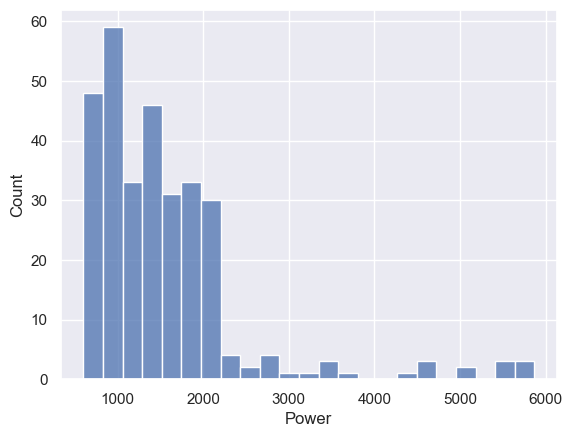

In [196]:
sns.histplot(df.Power.loc[(df.Power > 600) & (df.Power < 6000)])

Возможно пользователь ошибся и добавил лишние нули. Попробуем восстановить мощность по модели

Найдем среднее значение мощности для выбранных моделей

In [197]:
huge_power_models = df.loc[df.Power > 600].Model.unique().tolist()
median_power = {}
for model in huge_power_models:
    median = df["Power"].loc[df.Model == model].median()
    try:
        median_power[model] = round(median)
    except ValueError:
        print(model, "can't convert to int", median)


nan can't convert to int nan


Проверим реальность данных

#### Восстановим мощности из среднего

In [198]:
# Восстановим мощности
df["Power"].update(df.loc[df.Power > 600]["Model"].map(median_power))

In [199]:
# Оставшиеся большие мозности заменим на NaT
df.loc[df['Power'] > 600, 'Power'] = np.nan

In [200]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354315.0,106.476593,0.0,69.0,105.0,141.0,600.0,63.444768
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


#### Отфильтруем RegistrationDate удалив года, которые старше самой выборки или были выпущены раньше 1900г

In [201]:
df.RegistrationYear.loc[df.RegistrationYear > 2019].describe().T # Перебором года удалось выяснить граничный реальный год

count     105.000000
mean     6399.276190
std      2750.727549
min      2066.000000
25%      4100.000000
50%      5911.000000
75%      9996.000000
max      9999.000000
Name: RegistrationYear, dtype: float64

In [202]:
df.RegistrationYear.loc[df.RegistrationYear < 1900].describe().T

count      66.000000
mean     1181.924242
std       265.675529
min      1000.000000
25%      1000.000000
50%      1000.000000
75%      1288.750000
max      1800.000000
Name: RegistrationYear, dtype: float64

<Axes: >

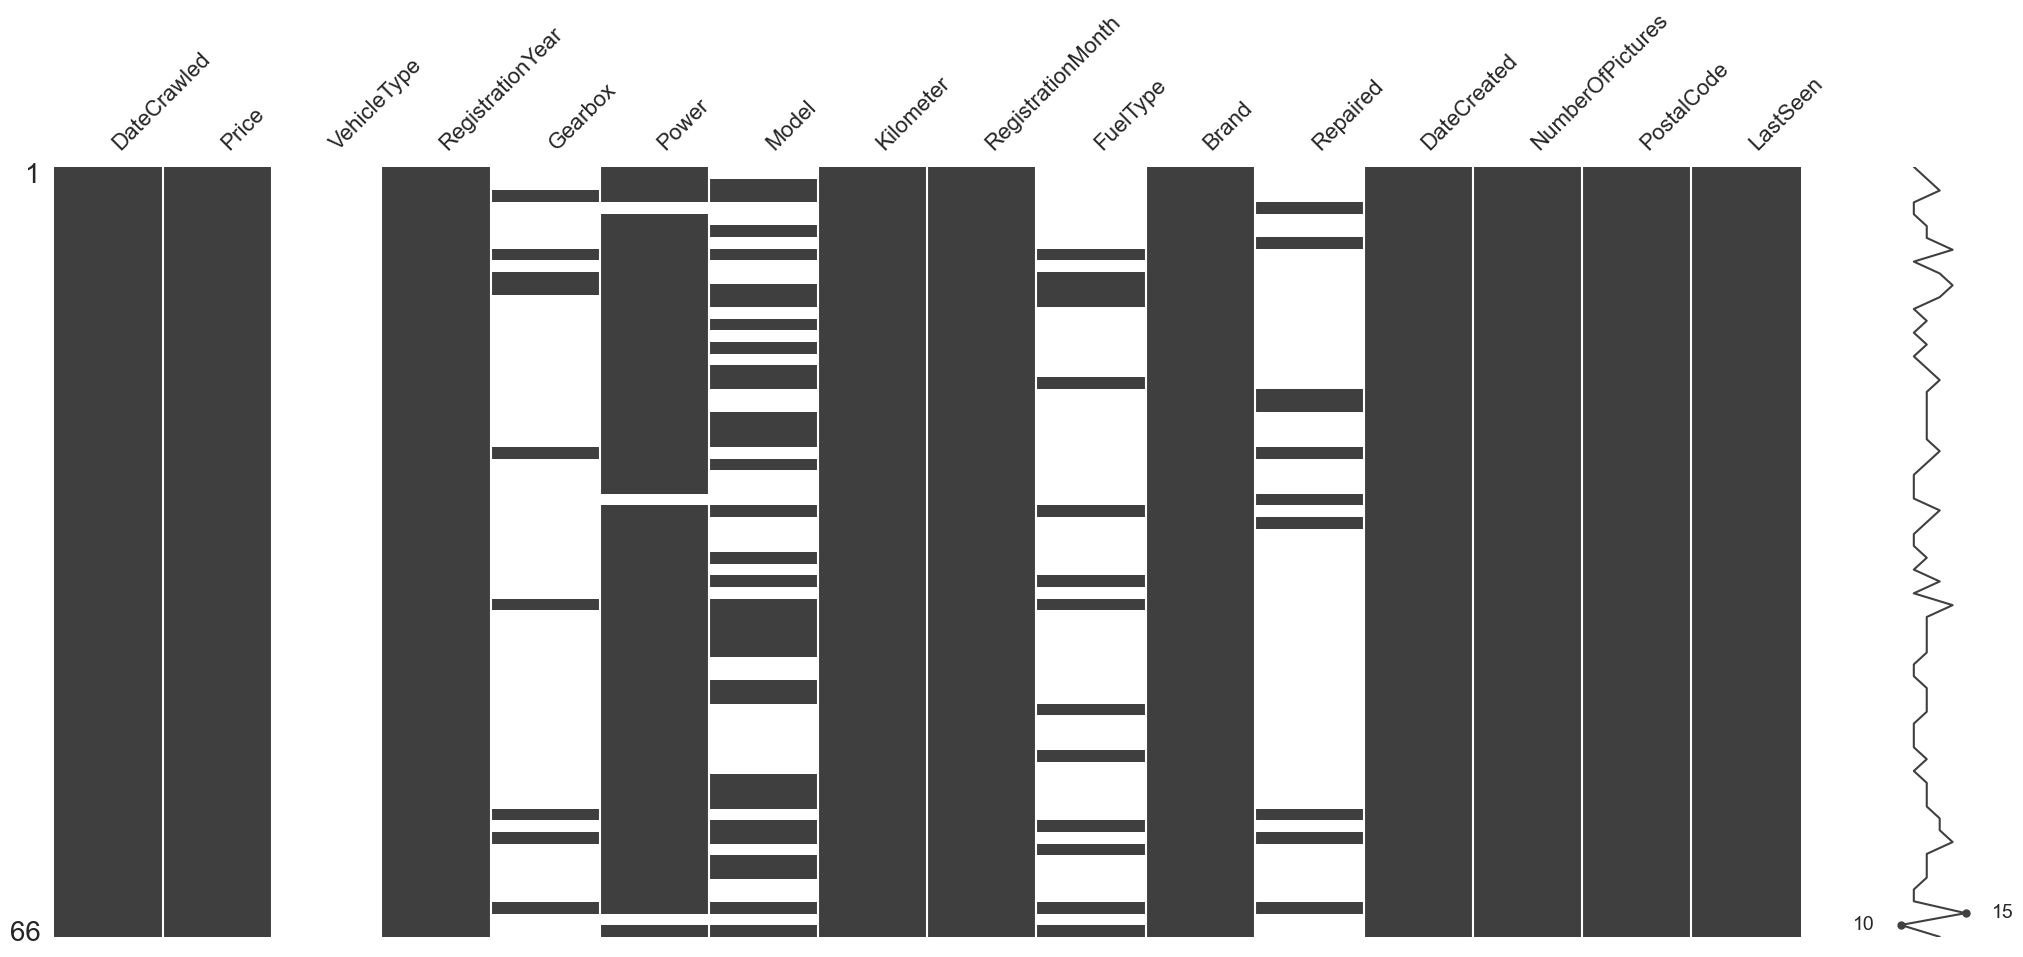

In [203]:
mn.missingno.matrix(df.loc[df.RegistrationYear < 1900])

<Axes: >

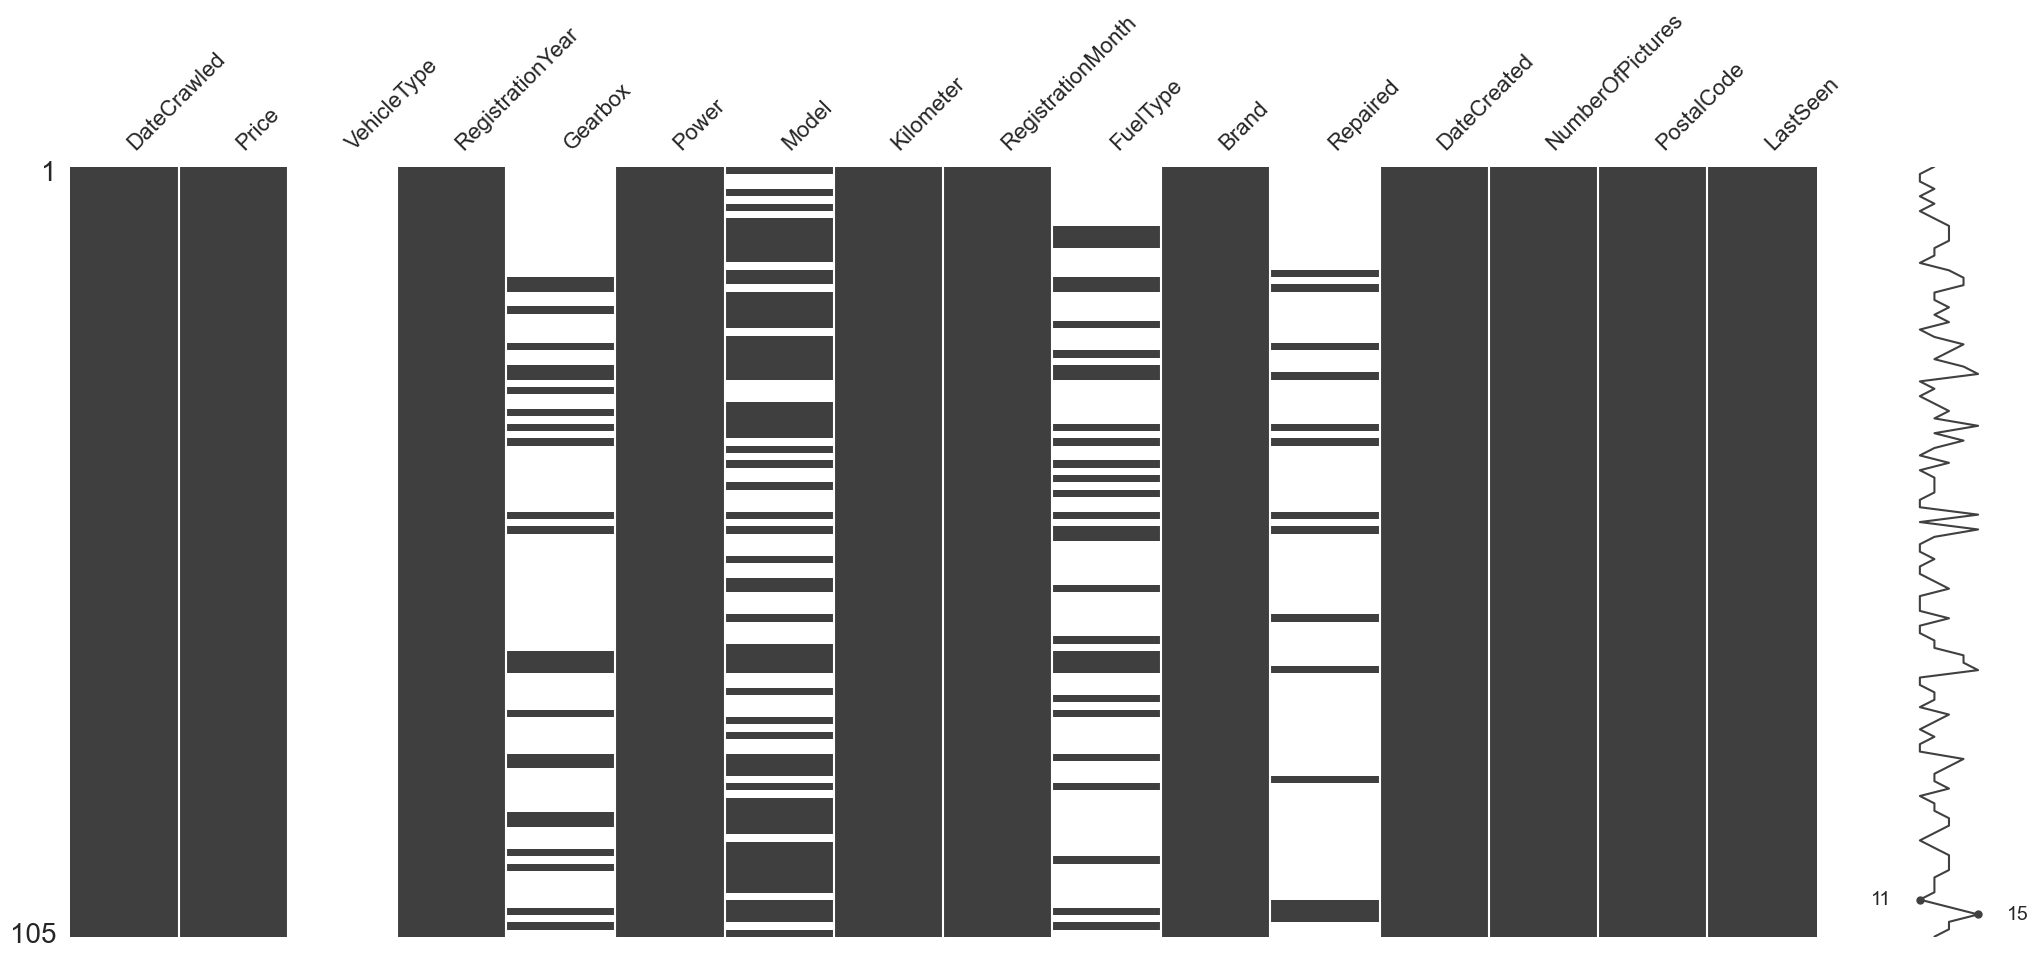

In [204]:
mn.missingno.matrix(df.loc[df.RegistrationYear > 2019])

Как видно, пользователи не удосужился заполнить объявление. Т.к. таких объявлений не много, то удаляем их

In [205]:
df = (df.drop(df.loc[df.RegistrationYear > 2019].index).
         drop(df.loc[df.RegistrationYear < 1900].index))
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354194,2016-03-21 12:57:58.108519936,2016-03-05 14:06:22,2016-03-13 11:52:27.750000128,2016-03-21 17:50:53.500000,2016-03-29 14:37:18.750000128,2016-04-07 14:36:58,NaN
Price,354194.0,4417.67439,0.0,1050.0,2700.0,6400.0,20000.0,4514.09886
RegistrationYear,354194.0,2003.084809,1910.0,1999.0,2003.0,2008.0,2019.0,7.536457
Power,354147.0,106.511276,0.0,69.0,105.0,141.0,600.0,63.415001
Kilometer,354194.0,128267.799567,5000.0,125000.0,150000.0,150000.0,150000.0,37823.278992
RegistrationMonth,354194.0,5.716825,0.0,3.0,6.0,9.0,12.0,3.725551
DateCreated,354194,2016-03-20 19:11:54.340728320,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354194.0,50511.608472,1067.0,30165.0,49413.0,71083.0,99998.0,25783.468198
LastSeen,354194,2016-03-29 23:50:49.900063232,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:43.500000,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


Проверим входные данные на соответствие нормальным

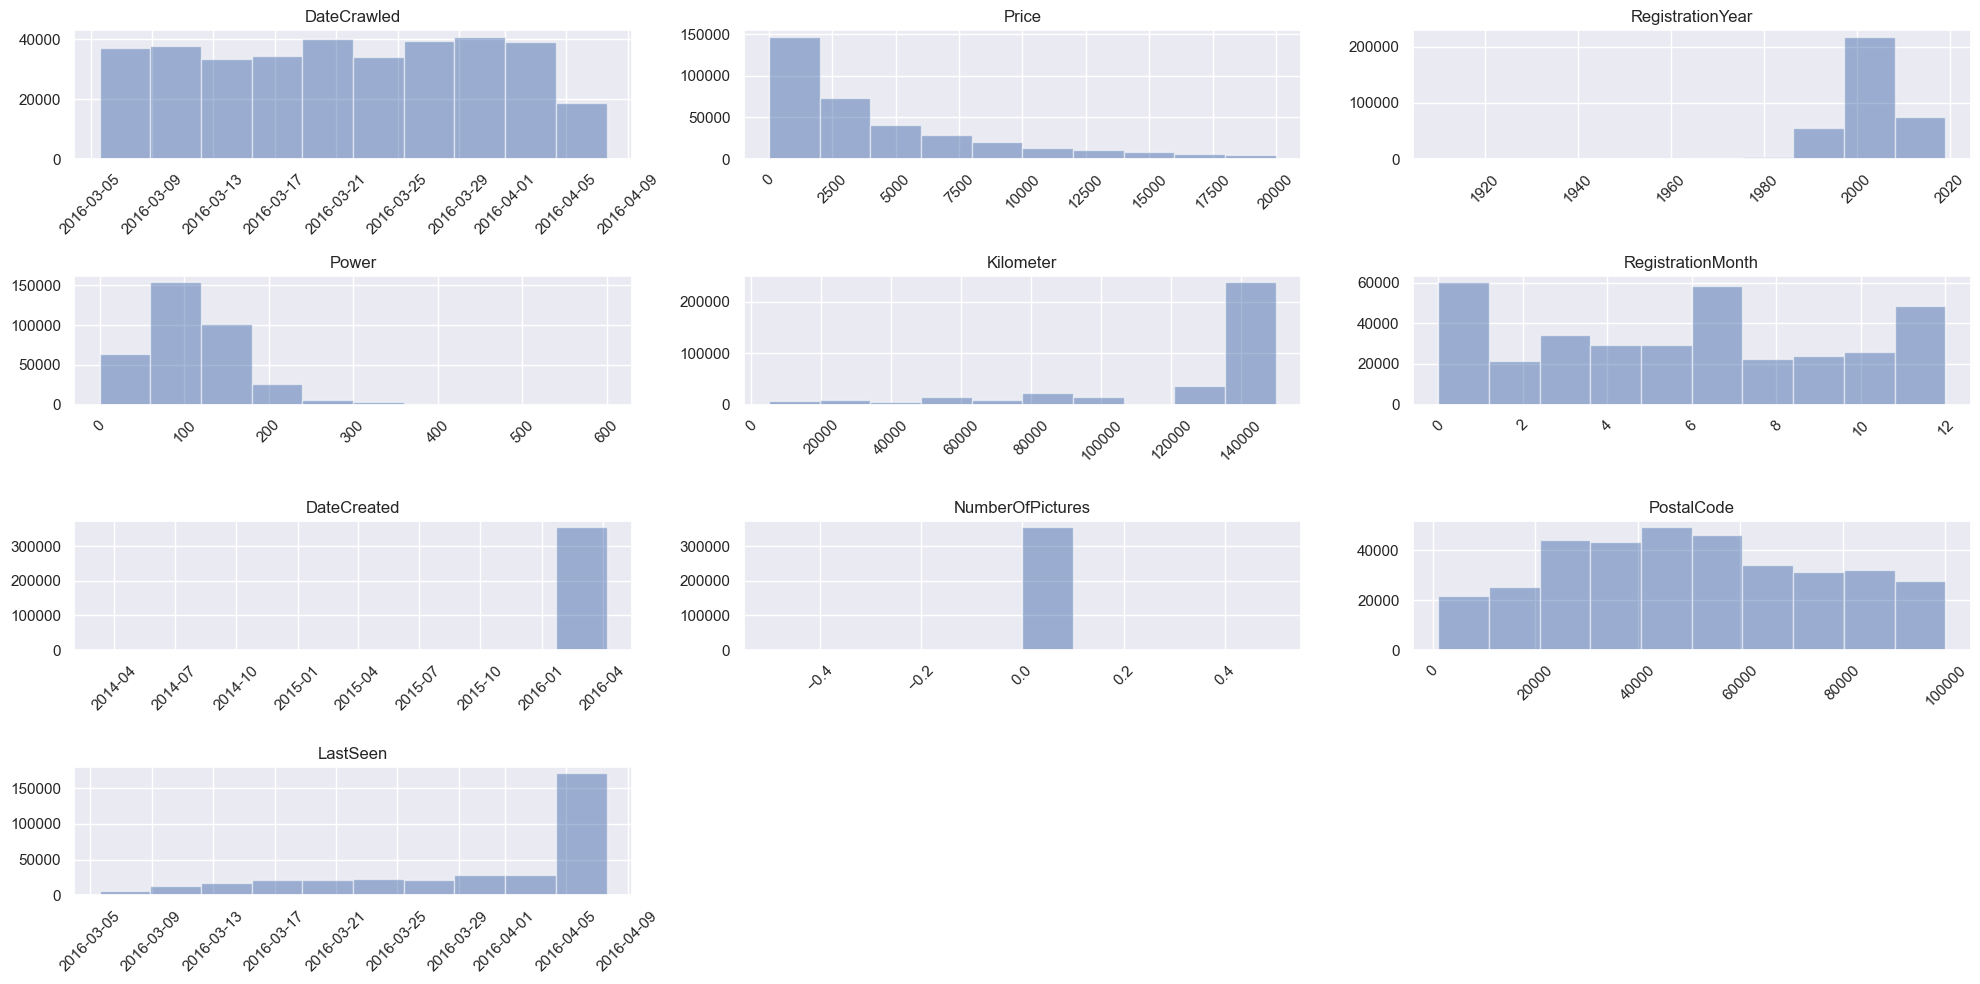

In [206]:
df.hist(alpha=0.5, figsize=(20, 10), xrot=45)
plt.tight_layout()
plt.show()


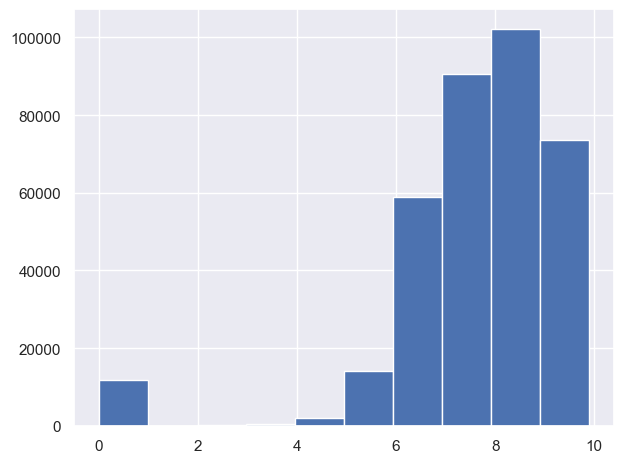

In [207]:
df["price_log"] = np.log1p(df["Price"])
df.price_log.hist()
plt.tight_layout()
plt.show()


Данные близки к нормальным, но выбивается нулевая цена. Такие объявления не несут ценности.


In [208]:
df = df.drop(columns=["price_log"]) 

#### Отбросим строки с незаполненной ценой, т.к. нередко в  объявлениях не указывают цены. Хоят товар не бесплатный.

In [209]:
df = df.loc[df.Price != 0]

## Преобразование данных в числа для дальнейшей обработки

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343454 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343454 non-null  datetime64[ns]
 1   Price              343454 non-null  int64         
 2   VehicleType        309843 non-null  category      
 3   RegistrationYear   343454 non-null  int64         
 4   Gearbox            326211 non-null  category      
 5   Power              343412 non-null  float64       
 6   Model              325986 non-null  category      
 7   Kilometer          343454 non-null  int64         
 8   RegistrationMonth  343454 non-null  int64         
 9   FuelType           314098 non-null  category      
 10  Brand              343454 non-null  category      
 11  Repaired           277706 non-null  category      
 12  DateCreated        343454 non-null  datetime64[ns]
 13  NumberOfPictures   343454 non-null  int64        

#### Изменим тип дат на int64


In [211]:
df["DateCrawled"] = df["DateCrawled"].astype("int64")
df["DateCreated"] = df["DateCreated"].astype("int64")
df["LastSeen"] = df["LastSeen"].astype("int64")

#### Преобразуем категории в числовые значение

Создадим функцию для преобразование категории в Int

In [212]:
def category_to_dict(col: pd.Series):
    map_ = {}
    for count, category in enumerate(col.unique()):
        if pd.isna(np.array([category,])):
            continue
        map_[category] = count

    return map_

In [213]:
categories_map = {}
for category in categorical_cols:
    map_ = category_to_dict(df[category])
    categories_map[category] = map_
    df[category] = df[category].map(map_).astype("Int16")

### Поиск коррелирующих данных

<Axes: >

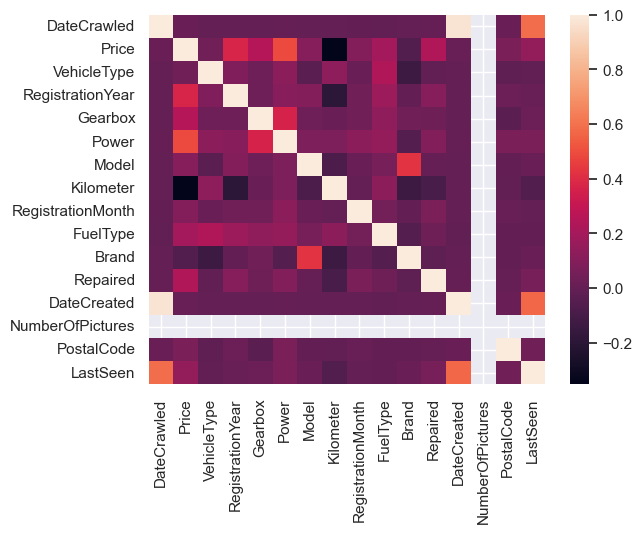

In [214]:
sns.heatmap(df.corr())

#### Видно, что DateCreated - DateCrawled имеют высокую корреляцию, NumberOfPictures - тоже можно удалить

In [215]:
df.drop(columns=["DateCrawled", "NumberOfPictures"], inplace=True)

In [217]:
categories_map["FuelType"]

{'petrol': 0,
 'gasoline': 1,
 'lpg': 3,
 'other': 4,
 'hybrid': 5,
 'cng': 6,
 'electric': 7}

Объедением petrol и gasoline, т.к. это одно и то же

In [218]:
df.FuelType = df.FuelType.replace(to_replace=1, value=0)

## Обработка пустых значение

In [219]:
df.isna().sum()

Price                    0
VehicleType          33611
RegistrationYear         0
Gearbox              17243
Power                   42
Model                17468
Kilometer                0
RegistrationMonth        0
FuelType             29356
Brand                    0
Repaired             65748
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

In [220]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,343454.0,4555.817556,4514.968053,1.0,1200.0,2890.0,6500.0,20000.0
VehicleType,309843.0,4.424402,1.765706,1.0,3.0,4.0,6.0,8.0
RegistrationYear,343454.0,2003.179066,7.371921,1910.0,1999.0,2003.0,2008.0,2019.0
Gearbox,326211.0,0.198834,0.399124,0.0,0.0,0.0,0.0,1.0
Power,343412.0,107.500012,62.865869,0.0,69.0,105.0,143.0,600.0
Model,325986.0,47.69049,48.957049,0.0,11.0,32.0,69.0,250.0
Kilometer,343454.0,128385.606224,37450.63075,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,343454.0,5.779749,3.697379,0.0,3.0,6.0,9.0,12.0
FuelType,314098.0,0.067632,0.497229,0.0,0.0,0.0,0.0,7.0
Brand,343454.0,7.75887,7.558027,0.0,1.0,6.0,11.0,39.0


## Проверим влияние признаков

In [221]:
df_clear = df.copy().dropna()
num_features_to_select = 3
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X = df_clear.drop("Price", axis=1)
y = df_clear["Price"]
selector.fit(X, y)

all_feature_scores = selector.scores_
feature_names = X.columns
for feature, score in zip(feature_names, all_feature_scores):
    print(f"Признак: {feature}, Оценка: {score}")

Признак: VehicleType, Оценка: 2.052118566551913
Признак: RegistrationYear, Оценка: 43.082827055139724
Признак: Gearbox, Оценка: 6.316633258840613
Признак: Power, Оценка: 26.83852380444396
Признак: Model, Оценка: 2.0894686788939056
Признак: Kilometer, Оценка: 16.081134531926914
Признак: RegistrationMonth, Оценка: 1.5564850200569724
Признак: FuelType, Оценка: 0.9352722263590406
Признак: Brand, Оценка: 1.7612637020406492
Признак: Repaired, Оценка: 12.849168340777384
Признак: DateCreated, Оценка: 1.1173979254871922
Признак: PostalCode, Оценка: 1.6086824718642612
Признак: LastSeen, Оценка: 2.9827411178110634


## Заполнение пропуском при помощи нейросетей

### Удалим безнадежные данные

In [222]:
df = (df.drop(df.loc[(df.Model.isnull()) & (df.Power.isnull())].index)
   .drop(df.loc[(df.Repaired.isnull()) & (df.Kilometer.isnull())].index)
   .drop(df.loc[(df.RegistrationYear.isnull()) &(df.Model.isnull())].index)
         )

In [223]:
df.isna().sum()

Price                    0
VehicleType          33605
RegistrationYear         0
Gearbox              17239
Power                    0
Model                17426
Kilometer                0
RegistrationMonth        0
FuelType             29345
Brand                    0
Repaired             65735
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

In [273]:
#df.dropna(inplace=True)

In [224]:

def predict_na_class(col_name: str, df_for_imputation: pd.DataFrame):
    need_to_predict = df_for_imputation.loc[df_for_imputation[col_name].isnull()].drop(col_name, axis=1)
    train_set = df_for_imputation.drop(need_to_predict.index).dropna()
    
    X = train_set.drop(col_name, axis=1)
    y = train_set[col_name]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=RANDOM_SEED)

    gbm = lightgbm.LGBMClassifier(random_state=33, early_stopping_rounds = 5, n_estimators=500)
    gbm.fit(X_train,  y_train, eval_set=[(X_test, y_test)])
    need_to_predict[col_name] =  gbm3.predict(need_to_predict)
    df_for_imputation.loc[df_for_imputation[col_name].isna(), col_name] = need_to_predict[col_name].values
    return df_for_imputation

In [227]:
df_for_imputation = df.copy().drop("Price", axis=1)
df_for_imputation = predict_na_class("VehicleType", df_for_imputation)

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1207
[LightGBM] [Info] Number of data points in the train set: 218181, number of used features: 12
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score -3.009025
[LightGBM] [Info] Start training from score -3.232749
[LightGBM] [Info] Start training from score -1.429955
[LightGBM] [Info] Start training from score -1.224335
[LightGBM] [Info] Start training from score -2.715254
[LightGBM] [Info] Start training from score -2.337807
[LightGBM] [Info] Start training from score -1.568690
[Light

ValueError: Number of features of the model must match the input. Model n_features_ is 13 and input n_features is 12

In [ ]:
#df_for_imputation = predict_na_class("Gearbox", df_for_imputation)

In [228]:
df_for_imputation = predict_na_class("Model", df_for_imputation)

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 218181, number of used features: 12
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score -2.501866
[LightGBM] [Info] Start training from score -6.213147
[LightGBM] [Info] Start training from score -4.969250
[LightGBM] [Info] Start training from score -2.806852
[LightGBM] [Info] Start training from score -4.158319
[LightGBM] [Info] Start training from score -6.098675
[LightGBM] [Info] Start training from score -4.528784
[LightGBM] [Info] Start training from score -3.504334
[LightGBM] [Info]

ValueError: Number of features of the model must match the input. Model n_features_ is 13 and input n_features is 12

In [ ]:
#df_for_imputation = predict_na_class("FuelType", df_for_imputation)

In [176]:
df_for_imputation = predict_na_class("Repaired", df_for_imputation)

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Number of positive: 219310, number of negative: 30599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 249909, number of used features: 12
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.877559 -> initscore=1.969519
[LightGBM] [Info] Start training from score 1.969519
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.340107


In [229]:
df_for_imputation.isnull().sum()

VehicleType          33605
RegistrationYear         0
Gearbox              17239
Power                    0
Model                17426
Kilometer                0
RegistrationMonth        0
FuelType             29345
Brand                    0
Repaired             65735
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

In [230]:
df_for_imputation.describe().T

,count,mean,std,min,25%,50%,75%,max
VehicleType,309807.0,4.424409,1.765678,1.0,3.0,4.0,6.0,8.0
RegistrationYear,343412.0,2003.179356,7.371289,1910.0,1999.0,2003.0,2008.0,2019.0
Gearbox,326173.0,0.198836,0.399125,0.0,0.0,0.0,0.0,1.0
Power,343412.0,107.500012,62.865869,0.0,69.0,105.0,143.0,600.0
Model,325986.0,47.69049,48.957049,0.0,11.0,32.0,69.0,250.0
Kilometer,343412.0,128386.762839,37449.123194,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,343412.0,5.779751,3.697316,0.0,3.0,6.0,9.0,12.0
FuelType,314067.0,0.067638,0.497253,0.0,0.0,0.0,0.0,7.0
Brand,343412.0,7.758756,7.558035,0.0,1.0,6.0,11.0,39.0
Repaired,277677.0,1.877437,0.327936,1.0,2.0,2.0,2.0,2.0


In [231]:
df_for_imputation["Price"] = df["Price"]

In [232]:
df = df_for_imputation.copy()

### Скалирование

In [233]:
X = df.drop('Price', axis=1)
y = df['Price']


In [234]:
scaler = StandardScaler()
scaler.fit(X) 

StandardScaler()

In [235]:
X = scaler.transform(X)

In [236]:
X = pd.DataFrame(X, index=y.index, columns=df.drop("Price", axis=1).columns)

In [237]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343412 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        309807 non-null  float64
 1   RegistrationYear   343412 non-null  float64
 2   Gearbox            326173 non-null  float64
 3   Power              343412 non-null  float64
 4   Model              325986 non-null  float64
 5   Kilometer          343412 non-null  float64
 6   RegistrationMonth  343412 non-null  float64
 7   FuelType           314067 non-null  float64
 8   Brand              343412 non-null  float64
 9   Repaired           277677 non-null  float64
 10  DateCreated        343412 non-null  float64
 11  PostalCode         343412 non-null  float64
 12  LastSeen           343412 non-null  float64
dtypes: float64(13)
memory usage: 44.7 MB


In [238]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED)

Через cross vlaidation


### XGBRegressor

In [187]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [6],
    'n_estimators': [550]
}


xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1, param_grid={'max_depth': [6], 'n_estimators': [550]},
             verbose=4)

In [188]:
root_mean_squared_error(y_test, grid_search.predict(X_test))

1569.4823441228996

In [189]:
param_grid = {
    'max_depth': [5],
    'n_estimators': [500]
}

xgb_model = xgb.XGBRegressor(device="cuda")

grid_gbm = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                        cv = 3, n_jobs = -1, verbose = 4)
grid_gbm.fit(X_train, y_train)

import pickle
with open("xgb_s", "wb") as f:
    pickle.dump(grid_gbm, f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [190]:
grid_gbm.best_score_

0.8674338236246567

In [191]:
root_mean_squared_error(y_test, grid_gbm.predict(X_test))

1588.289301012583

### LightGBM

In [ ]:
!python -m pip install lightgbm


In [239]:
import lightgbm
gbm3 = lightgbm.LGBMRegressor(random_state=33, early_stopping_rounds = 5, n_estimators=500)
gbm3.fit(X_train,  y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 309070, number of used features: 13
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Info] Start training from score 4555.922040
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 1592.8	valid_0's l2: 2.53702e+06


LGBMRegressor(early_stopping_rounds=5, n_estimators=500, random_state=33)

## Вывод

Бустинговые модели дают примерно одинаковый вариант
<p>Исходные данные даны в достаточном количестве. Но среди них есть много данных, которые искажают результат и правильная их обработка оказывает значительное влияние.
<p> Безо всякой фильтрации, оставив только преобразование типов RMSE 1738
<P><P>
<p> - Если не удалять пустые данные - RMSE 1600
<p>       Со скалированием 1579
<p> - Удаление всех пустых - RMSE 1615
          Со скалированием 1511
<p> Восстановление данных с помощью моделей привело к снижению точности до 1600